# Barrier Option Pricing with Brownian Bridge Correction

In Monte Carlo simulations of barrier options, path discretization can miss barrier crossings between time steps. This leads to **upward-biased prices** for knock-out options and **downward-biased prices** for knock-in options.

To address this, we implement the **Brownian Bridge Correction**, a method that estimates the probability of hitting the barrier *between* discrete simulation steps.

We’ll compare naive and corrected Monte Carlo pricing for an Up-and-Out Call.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

## Brownian Bridge for Barrier Correction

If we simulate asset prices at discrete time points, we may *miss barrier crossings* between them. The Brownian bridge assumes that between two known values of the process, the path behaves like a Brownian motion conditioned to end at the next point.

For a time interval $[t_i, t_{i+1}]$:
- Start: $S_i$
- End: $S_{i+1}$

The probability that the barrier $B$ is breached **at any time** between $t_i$ and $t_{i+1}$ is:

\[
P_{\text{cross}} = \exp\left( \frac{-2 \cdot \log(S_i/B) \cdot \log(S_{i+1}/B)}{\sigma^2 \cdot \Delta t} \right)
\]

We use this probability to adjust the indicator function for barrier crossing.

In [25]:
def simulate_up_and_out_call_bb(S0, K, B, T, r, sigma, n_paths, n_steps):
    dt = T / n_steps
    discount = np.exp(-r * T)
    
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0

    # Generate paths
    for t in range(1, n_steps + 1):
        z = np.random.randn(n_paths)
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    # Naive: Check if barrier ever crossed
    barrier_crossed_naive = np.any(paths >= B, axis=1)

    # Brownian Bridge correction
    crossed_bb = np.zeros(n_paths)
    for i in range(n_paths):
        crossed = False
        for t in range(n_steps):
            S_i = paths[i, t]
            S_ip1 = paths[i, t + 1]
            if S_i < B and S_ip1 < B:
                prob_cross = np.exp(-2 * np.log(S_i / B) * np.log(S_ip1 / B) / (sigma**2 * dt))
                if np.random.rand() < prob_cross:
                    crossed = True
                    break
            elif S_i >= B or S_ip1 >= B:
                crossed = True
                break
        crossed_bb[i] = crossed

    # Payoffs
    payoff_naive = np.where(barrier_crossed_naive, 0, np.maximum(paths[:, -1] - K, 0))
    payoff_bb = np.where(crossed_bb, 0, np.maximum(paths[:, -1] - K, 0))

    price_naive = discount * np.mean(payoff_naive)
    price_bb = discount * np.mean(payoff_bb)

    return price_naive, price_bb

In [26]:
# Parameters
S0 = 100
K = 100
B = 120   # Up-and-Out
T = 1.0
r = 0.05
sigma = 0.2
n_paths = 100000
n_steps = 50

price_naive, price_bb = simulate_up_and_out_call_bb(S0, K, B, T, r, sigma, n_paths, n_steps)

print(f"Naive MC Price:         {price_naive:.4f}")
print(f"Brownian Bridge Price:  {price_bb:.4f}")

Naive MC Price:         1.5338
Brownian Bridge Price:  1.1903


##  Summary

- The naive Monte Carlo simulation **overestimates** the price of barrier options by missing barrier crossings.
- The Brownian Bridge method significantly **corrects this bias** by estimating the probability of an intra-step crossing.
- Especially with coarser time steps or high barriers, this correction is essential for accurate pricing.

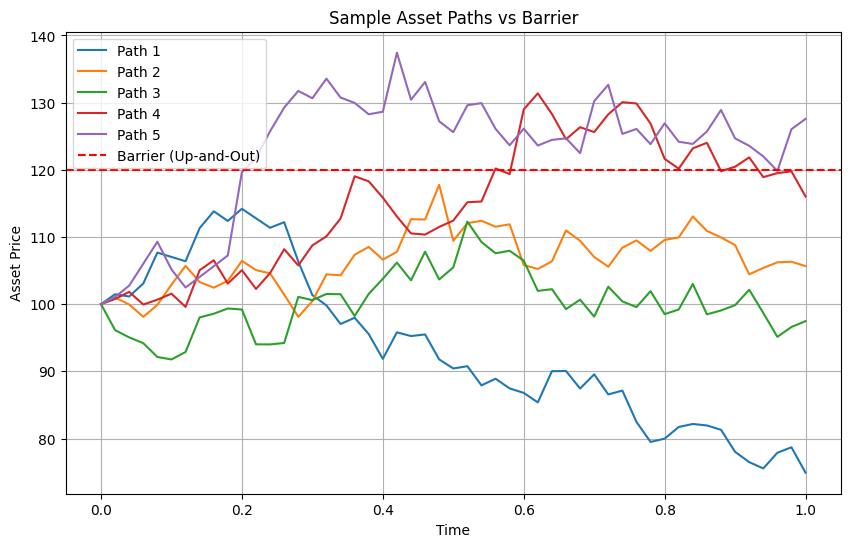

In [27]:
# Parameters
dt = T / n_steps
paths = 5

np.random.seed(42)
S_paths = np.zeros((paths, n_steps + 1))
S_paths[:, 0] = S0

for i in range(paths):
    for t in range(1, n_steps + 1):
        z = np.random.randn()
        S_paths[i, t] = S_paths[i, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

# Plot sample paths
plt.figure(figsize=(10, 6))
for i in range(paths):
    plt.plot(np.linspace(0, T, n_steps + 1), S_paths[i], label=f'Path {i+1}')
plt.axhline(B, color='red', linestyle='--', label='Barrier (Up-and-Out)')
plt.title('Sample Asset Paths vs Barrier')
plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.legend()
plt.grid(True)
plt.show()